In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

In [16]:
window = 20

file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
df = pd.read_csv(file_path, parse_dates=True)

df = df.sort_values(by='Date')

targ = 'LMCADY_acu_{}d_log'.format(window)
time_series = df[targ]

time_series

0       0.081352
1       0.075898
2       0.068538
3       0.055772
4       0.046443
          ...   
5530    0.055556
5531    0.053156
5532    0.073317
5533    0.088143
5534    0.112357
Name: LMCADY_acu_20d_log, Length: 5535, dtype: float64

In [17]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.01, shuffle=False)

In [18]:
LMCADY_train

0       0.081352
1       0.075898
2       0.068538
3       0.055772
4       0.046443
          ...   
5474   -0.001877
5475   -0.001054
5476    0.008406
5477    0.009693
5478    0.006872
Name: LMCADY_acu_20d_log, Length: 5479, dtype: float64

In [19]:
def evaluate_ar_model(train_series, test_series, lags=5):

    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()

    for actual in test_series:
        if len(current_train) <= lags:
            print(f"No hay suficientes observaciones para {lags} lags. Terminando el ciclo.")
            break

        model = AutoReg(current_train, lags=lags)
        model_fit = model.fit()

        prediction = model_fit.predict(start=len(current_train), end=len(current_train), dynamic=False)

        predictions.append(prediction.iloc[0])
        # print("pred {:.6f}, {:.6f}".format(prediction.iloc[0],actual))

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [20]:
def calculate_rmse(predictions, actual):
    # Asegurarse de que las series sean de igual longitud
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    # Calcular el RMSE
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [21]:
stop_lag = 100

best_predictions = None
best_lags = None
best_rmse = 999.9

for lags in range(0,stop_lag+1,1):
    LMCADY_predictions = evaluate_ar_model(LMCADY_train, LMCADY_test, lags=lags)
    LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)
    print(f"AR> RMSE para {lags} lags: {LMCADY_rmse:.6f}")

    if LMCADY_rmse < best_rmse:
        best_rmse = LMCADY_rmse
        best_lags = lags
        best_predictions = LMCADY_predictions

AR> RMSE para 0 lags: 0.043611
AR> RMSE para 1 lags: 0.013478


AR> RMSE para 2 lags: 0.013486
AR> RMSE para 3 lags: 0.013479
AR> RMSE para 4 lags: 0.013475
AR> RMSE para 5 lags: 0.013464
AR> RMSE para 6 lags: 0.013525
AR> RMSE para 7 lags: 0.013517
AR> RMSE para 8 lags: 0.013607
AR> RMSE para 9 lags: 0.013625
AR> RMSE para 10 lags: 0.013630
AR> RMSE para 11 lags: 0.013668
AR> RMSE para 12 lags: 0.013695
AR> RMSE para 13 lags: 0.013698
AR> RMSE para 14 lags: 0.013691
AR> RMSE para 15 lags: 0.013703
AR> RMSE para 16 lags: 0.013690
AR> RMSE para 17 lags: 0.013605
AR> RMSE para 18 lags: 0.013575
AR> RMSE para 19 lags: 0.013569
AR> RMSE para 20 lags: 0.013427
AR> RMSE para 21 lags: 0.013035
AR> RMSE para 22 lags: 0.013064
AR> RMSE para 23 lags: 0.013067
AR> RMSE para 24 lags: 0.013067
AR> RMSE para 25 lags: 0.013066
AR> RMSE para 26 lags: 0.013062
AR> RMSE para 27 lags: 0.013062
AR> RMSE para 28 lags: 0.013116
AR> RMSE para 29 lags: 0.013163
AR> RMSE para 30 lags: 0.013167
AR> RMSE para 31 lags: 0.013194
AR> RMSE para 32 lags: 0.013208
AR> RMSE para 33

In [22]:
std_prueba = LMCADY_test.describe()['std']
print("El mejor rendimiento: {} lags, rmse = {:.6f} vs. std = {:.6f}".format(best_lags,best_rmse,std_prueba))

El mejor rendimiento: 100 lags, rmse = 0.011403 vs. std = 0.034529


In [23]:
def plot_predictions(test_series, predictions, title):
    plt.figure(figsize=(12, 6))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-')
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--')

    plt.title(f"AR Model: {title}")
    plt.legend()
    plt.show()

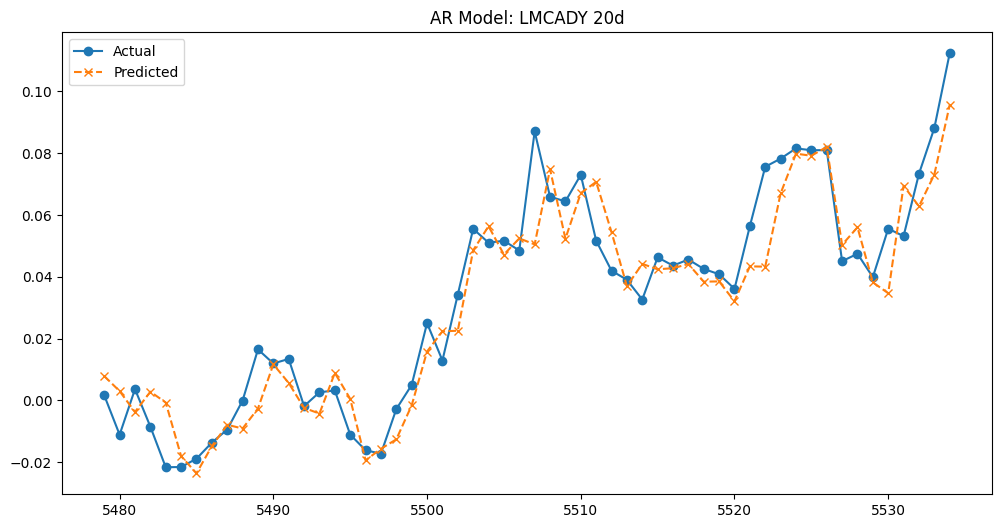

In [24]:
plot_predictions(LMCADY_test, best_predictions, "LMCADY {}d".format(window))